In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import pickle
import nltk
nltk.download('punkt')
import itertools
import time
import scipy.sparse as sparse
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

[nltk_data] Downloading package punkt to /Users/wangzh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data = np.float64(np.load("../MNIST.npy"))
labels = np.float64(np.load("../MNIST_labels.npy"))
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data,labels,
                                                 test_size = float(2/7), 
                                                 random_state = 12345)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,
                                               test_size = 0.5,
                                               random_state = 12345)

In [3]:
mytrain_x = X_train[:5000]
mytrain_y = y_train[:5000]
mytest_x = X_test[:100]
mytest_y = y_test[:100]
myval_x = X_val[:500]
myval_y = y_val[:500]


# (a) Experiment with RandomForestClassifier

In [3]:
num_trees = 10
min_sam =100
max_fea = 50
clf = RandomForestClassifier(
    n_estimators=num_trees,min_samples_split=min_sam,criterion = "entropy",
max_features = max_fea)

clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=50, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [4]:
pred_val = clf.predict(X_val)

In [6]:
error = np.count_nonzero(pred_val - y_val)/len(y_val)

In [7]:
error

0.0715

In [8]:
pred_prob_val = clf.predict_proba(X_val)

In [9]:
pred_prob_val.shape

(10000, 10)

In [57]:
def my_forest(num_trees,min_sam=10,max_fea=10):
    clf = RandomForestClassifier(
    n_estimators=num_trees,min_samples_split=min_sam,criterion = "entropy",
max_features = max_fea)
    
    start = time.time()
    clf.fit(X_train,y_train)
    fit_time = time.time() - start
    
    pred_tra = clf.predict(X_train)
    pred_val = clf.predict(X_val)
    
    err_val = np.count_nonzero(pred_val - y_val)/len(y_val)
    err_tra = np.count_nonzero(pred_tra - y_train)/len(y_train)
    
    return(err_tra,err_val,fit_time)
    

In [58]:
my_forest(num_trees=10)

(0.0105, 0.0632, 1.2128288745880127)

## Fix min_samples = 10 and max_features = 10 and tune num_trees

In [59]:
nums_trees = [10,20,30,40,100,1000,600]
#nums_trees = [10,20,30,40,100]
errs_tra = []
errs_val = []
times = []
for x in nums_trees:
    e1,e2,t = my_forest(num_trees=x)
    errs_tra.append(e1)
    errs_val.append(e2)
    times.append(t)
    

In [79]:
times

[1.3836920261383057,
 2.726815938949585,
 3.9291470050811768,
 5.191199779510498,
 12.848658084869385,
 130.29941511154175,
 76.91189503669739]

In [72]:
nums_trees = [10,20,30,40,100,1000,600]

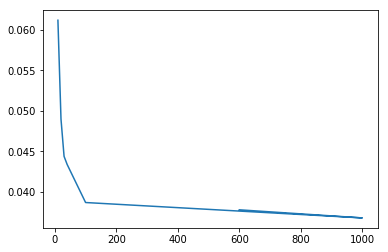

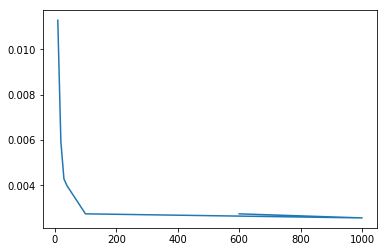

In [75]:
plt.plot(nums_trees,errs_val)
plt.show()
plt.plot(nums_trees,errs_tra)

### Comment:
From the results above we can see that increased number of trees help reduce variance and therefore reduce error on both training and validation data. However, when the tree number is big enough, the improvement is not that significant compared to when the number of trees is small. 

## Fix num_trees = 5, min_samples = 10, and tune max_features

In [62]:
max_fea = [10,30,50,70,90]
errs_tra_f = []
errs_val_f = []
times_f = []
for x in max_fea:
    e1,e2,t = my_forest(num_trees=5,max_fea=x)
    errs_tra_f.append(e1)
    errs_val_f.append(e2)
    times_f.append(t)

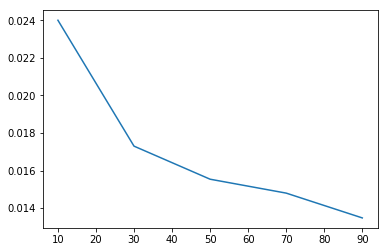

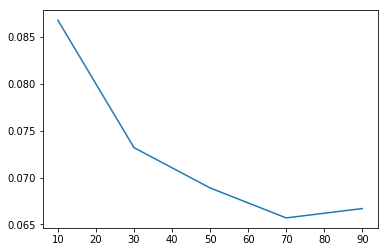

In [64]:
plt.plot(max_fea,errs_tra_f)
plt.show()
plt.plot(max_fea,errs_val_f)

### Comment:
From the results above, we can see increased number of max_features help reduce error rate on both training and validation data, until it reaches a certain number (70 in this case). However, the effect of max_features is correlated with min_samples. So comprehensive experiements are needed. 

## Fix num_trees = 10, max_features =70 and tune min_samples

In [69]:
min_samples = [3,5,10,50,100,500]
errs_tra_s = []
errs_val_s = []
times_s = []
for x in min_samples:
    e1,e2,t = my_forest(num_trees=5,max_fea=70,min_sam=x)
    errs_tra_s.append(e1)
    errs_val_s.append(e2)
    times_s.append(t)

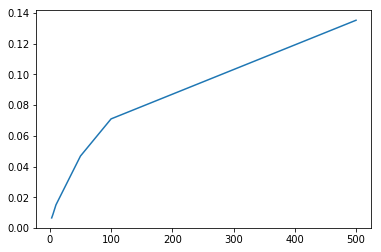

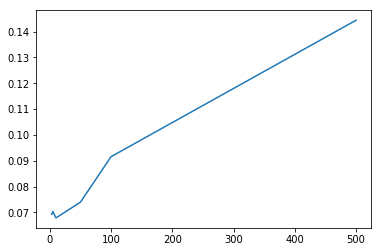

In [70]:
plt.plot(min_samples,errs_tra_s)
plt.show()
plt.plot(min_samples,errs_val_s)

### Comment:
From the results above we can see the improvement decreases with increasing number of min_samples, until it is too small (3, in this case) which will cause overfitting. However, as there is correlatio between min_samples and max_features, more comprehensive experiments are needed.

## Run on test data with best protocol
For effiency concern I use 100 trees. Then the combination is (num_trees = 100, min_samples = 10, max_samples = 70)

In [71]:
num_trees = 100
min_sam =10
max_fea = 70
clf = RandomForestClassifier(
    n_estimators=num_trees,min_samples_split=min_sam,criterion = "entropy",
max_features = max_fea)
clf.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=70, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [72]:
pred_test = clf.predict(X_test)
err_test = np.count_nonzero(pred_test - y_test)/len(y_test)
err_test

0.0354

# (b) 

In [71]:
def my_boostforest(n_estimators=10,min_sam=10,max_fea=10, num_trees=1):
    clfb = RandomForestClassifier(
    n_estimators=num_trees,min_samples_split=min_sam,criterion = "entropy",
    max_features = max_fea)
    adb = AdaBoostClassifier(
        clfb,n_estimators=n_estimators,algorithm='SAMME',random_state=12345)
    start = time.time()
    adb.fit(X_train,y_train)
    fit_time = time.time() - start
    
    return(adb,fit_time)

In [97]:
my_boostforest()

(AdaBoostClassifier(algorithm='SAMME',
           base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=None, max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
           learning_rate=1.0, n_estimators=10, random_state=12345),
 1.8059000968933105)

In [45]:
def predict_eval(adb,X=X_val,y=y_val):
    adb_pred = adb.predict(X)
    adb_err = np.count_nonzero(adb_pred - y)/len(y)
    return(adb_err)

## Fix min_samples = 10, max_features = 10, num_trees = 1, and tune n_estimators

In [73]:
nums_est = [10,50,100,150,200]
adbs = []
adb_times = []
adbne_errs_val = []
adbne_errs_tra = []
for x in nums_est:
    a,t = my_boostforest(n_estimators=x)
    adbs.append(a)
    adb_times.append(t)
    adbne_errs_tra.append(predict_eval(a,X=X_train,y=y_train))
    adbne_errs_val.append(predict_eval(a,X=X_val,y=y_val))

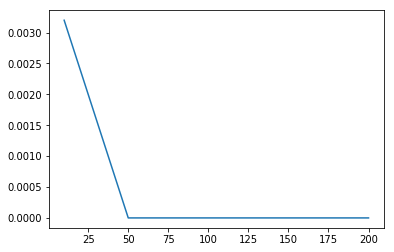

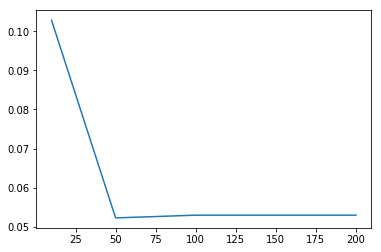

In [76]:
plt.plot(nums_est,adbne_errs_tra)
plt.show()
plt.plot(nums_est,adbne_errs_val)
plt.show()

### Comment:
From results above, we can see n_estimates = 50 is sufficent.

## Fix n_estimators = 10, min_samples = 10, num_trees = 1, and tune max_features

In [80]:
max_fea = [10,50,100]
adbs_f = []
adb_times_f = []
adbf_errs_val = []
adbf_errs_tra = []
for x in max_fea:
    a,t = my_boostforest(n_estimators=10,max_fea=x)
    adbs_f.append(a)
    adb_times_f.append(t)
    adbf_errs_tra.append(predict_eval(a,X=X_train,y=y_train))
    adbf_errs_val.append(predict_eval(a,X=X_val,y=y_val))

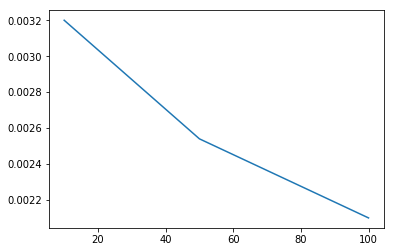

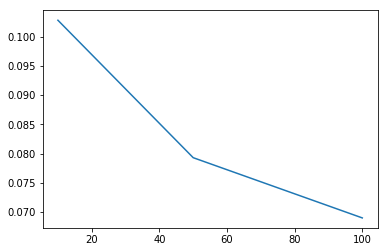

In [81]:
plt.plot(max_fea,adbf_errs_tra)
plt.show()
plt.plot(max_fea,adbf_errs_val)
plt.show()

In [82]:
max_fea2 = [200,300]
for x in max_fea2:
    a,t = my_boostforest(n_estimators=10,max_fea=x)
    adbs_f.append(a)
    adb_times_f.append(t)
    adbf_errs_tra.append(predict_eval(a,X=X_train,y=y_train))
    adbf_errs_val.append(predict_eval(a,X=X_val,y=y_val))

In [83]:
adbf_errs_val

[0.1028, 0.0793, 0.069, 0.0674, 0.062]

In [84]:
adb_times_f

[1.8186509609222412,
 5.622082948684692,
 10.067394256591797,
 18.769381046295166,
 27.02329421043396]

In [85]:
max_fea3 = [500]
for x in max_fea3:
    a,t = my_boostforest(n_estimators=10,max_fea=x)
    adbs_f.append(a)
    adb_times_f.append(t)
    adbf_errs_tra.append(predict_eval(a,X=X_train,y=y_train))
    adbf_errs_val.append(predict_eval(a,X=X_val,y=y_val))

In [89]:
max_fea4 = [700]
for x in max_fea4:
    a,t = my_boostforest(n_estimators=10,max_fea=x)
    adbs_f.append(a)
    adb_times_f.append(t)
    adbf_errs_tra.append(predict_eval(a,X=X_train,y=y_train))
    adbf_errs_val.append(predict_eval(a,X=X_val,y=y_val))

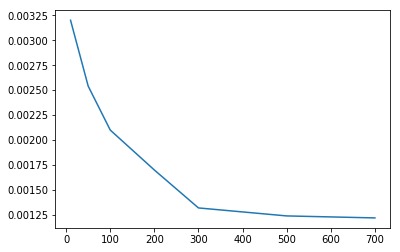

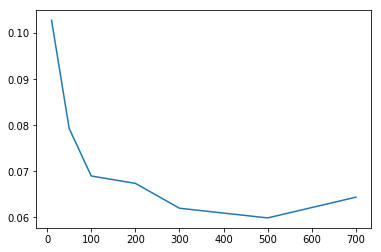

In [92]:
plt.plot(max_fea+max_fea2+max_fea3+max_fea4,adbf_errs_tra)
plt.show()
plt.plot(max_fea+max_fea2+max_fea3+max_fea4,adbf_errs_val)
plt.show()

### Comment:
From results above, we can see the best performance on validation data is achieved at max_features = 500, much higher than in RandomForestClassifier. 

## Fix n_estimators = 10, max_features = 10, num_trees = 1, and tune min_samples 

In [94]:
min_sam = [10,50,100,500]
adbs_s = []
adb_times_s = []
adbs_errs_tra = []
adbs_errs_val = []
for x in min_sam:
    a,t = my_boostforest(n_estimators=10,min_sam = x)
    adbs_s.append(a)
    adb_times_s.append(t)
    adbs_errs_tra.append(predict_eval(a,X=X_train,y=y_train))
    adbs_errs_val.append(predict_eval(a,X=X_val,y=y_val))

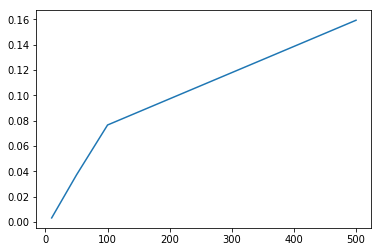

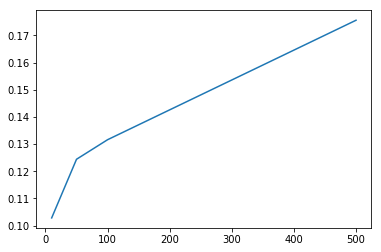

In [95]:
plt.plot(min_sam,adbs_errs_tra)
plt.show()
plt.plot(min_sam,adbs_errs_val)
plt.show()

### Comment:
Similar to previous cases, error rate on both training and validation increases as min_samples increase.

## Fix n_estimators = 10, max_features = 10, min_samples = 10, and tune num_trees  

In [101]:
num_trees = [1,10,30,50]
adbs_t = []
adb_times_t = []
adbt_errs_tra = []
adbt_errs_val = []
for x in num_trees:
    a,t = my_boostforest(n_estimators=10,num_trees = x)
    adbs_t.append(a)
    adb_times_t.append(t)
    adbt_errs_tra.append(predict_eval(a,X=X_train,y=y_train))
    adbt_errs_val.append(predict_eval(a,X=X_val,y=y_val))

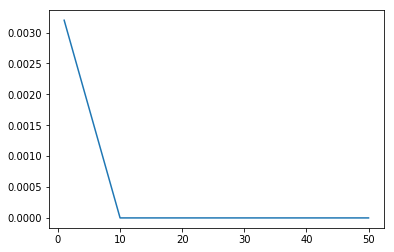

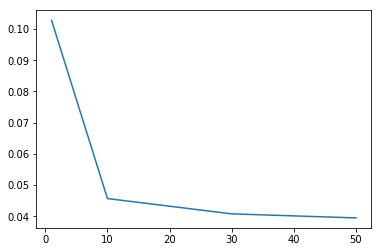

In [102]:
plt.plot(num_trees,adbt_errs_tra)
plt.show()
plt.plot(num_trees,adbt_errs_val)
plt.show()

### Comment:
From results above, we can see error_rate decreases as the number of trees in the base_estimator increases. However, it is sufficient to use num_trees = 10 as the improvement gets very small when the tree number gets bigger.

## Run on test data with best protocol
Considering effiency we set (num_trees = 10, n_estimators = 50, min_samples = 10, max_features = 10)

In [104]:
best_adb,t = my_boostforest(num_trees = 10, n_estimators= 50, min_sam = 10, max_fea = 10)

In [106]:
best_adb_err_test = predict_eval(best_adb,X=X_test,y=y_test)

In [107]:
best_adb_err_test

0.0337

### Comparison with RandomForestClassifier
The best error rate decreases a little bit compared with the previous best model. The max_features is much larger in order to achieve good result. 

# (c) implement differen reweighting rule 

In [4]:
## fit model with boost random forest with weight update: w = w/e
def my_boostforest2(num_est=10, num_trees = 10, min_sam = 10, max_fea = 10,
                    X = mytrain_x, y = mytrain_y):
    
    ## initialzation
    l = len(y)
    trees = []
    weights = np.array([1/float(l)]*l)
    
    for i in range(num_trees):
        clf = RandomForestClassifier(
        n_estimators=num_est, min_samples_split=min_sam,max_features=max_fea, 
        criterion= "entropy")
        new_tree = clf.fit(X,y, sample_weight = weights)
        
        ## get error terms
        pred = new_tree.predict(X)
        err_index = np.nonzero(pred - y)[0]
        ## update weights
        e = weights[err_index].sum()
        weights[err_index] = weights[err_index]/e
        weights = weights/weights.sum()
        trees.append(new_tree)
    return(trees)   

In [5]:
def my_trees_predict(trees, X=mytest_x):
    whole_proba = np.zeros(shape=(X.shape[0],10,len(trees)))
    for i,t in enumerate(trees):
        whole_proba[:,:,i] = t.predict_proba(X)
    
    mean_proba = whole_proba.mean(axis = 2)
    #final_proba = mean_proba.mean(axis = 1)
    
    return(mean_proba.argmax(axis = 1))

In [6]:
def exper_mybforest2(num_est = 10, num_trees = 10, min_sam = 10, max_fea = 10,
                    X = X_train, y = y_train, X_v = X_val, y_v = y_val):
    
    start =time.time()
    trees = my_boostforest2(num_est = num_est, num_trees = num_trees, min_sam = min_sam, max_fea = max_fea,
                    X = X, y = y)
    fit_time = time.time() - start
    train_err = np.count_nonzero(my_trees_predict(trees, X=X)- y)/len(y) 
    val_err = np.count_nonzero(my_trees_predict(trees, X=X_v)- y_v)/len(y_v)
    return(train_err, val_err, fit_time)

In [7]:
import random
random.seed(12345)
exper_mybforest2(max_fea = 100)

(0.0, 0.0319, 94.53871297836304)

## Comparison

In [10]:
exper_mybforest2(num_est=1,num_trees=80,min_sam=10, max_fea=100)

(0.0, 0.0325, 97.89373207092285)

In [8]:
exper_mybforest2(num_trees=10,min_sam=10, max_fea=200)

(0.0, 0.0334, 183.90890407562256)

In [9]:
exper_mybforest2(num_est=5,num_trees=10,min_sam=10, max_fea=100)

(0.0, 0.0356, 49.37372612953186)

In the few experiments above I tried two different strategies: one is to grow one tree sequentially and grow many trees; the other is to grow one forest (10 trees say) sequentially and grow fewer forests. The result shows the first one works better (as indicated in the requirement in the assignment). Then we carry out experiment on test data.

In [11]:
exper_mybforest2(num_est=1,num_trees=80,min_sam=10, max_fea=100, X_v = X_test, y_v = y_test)

(0.0, 0.0316, 98.30693411827087)

### Comment:
The error rate on test data reports an error rate of 0.0316, better than all previous results.

# (d)

In [25]:
from sklearn.svm import SVC

In [45]:
def my_SVM(pen=1, X=X_train, y = y_train, X_v = X_val, y_v = y_val, X_t = X_test, y_t = y_test):
    gsvm=SVC(kernel='rbf',C=1./pen)
    start = time.time()
    gsvm.fit(X,y)
    fit_time = time.time() - start
    print("Fit finished after: " + str(fit_time) )
    
    start = time.time()
    train_err = np.count_nonzero(gsvm.predict(X) - y)/len(y)
    pred_time1 = time.time() -start
    print("Training data prediction finished after: " + str(pred_time1))
    print("error rates on the training is: " + str(train_err))
    
    start = time.time()
    val_err = np.count_nonzero(gsvm.predict(X_v) - y_v)/len(y_v)
    pred_time2 = time.time() -start
    print("Validation data prediction finished after: " + str(pred_time2))
    print("error rates on the validation data is: " + str(val_err))
    
    start = time.time()
    test_err = np.count_nonzero(gsvm.predict(X_t) - y_t)/len(y_t)
    pred_time3 = time.time() -start
    print("Test data prediction finished after: " + str(pred_time3))
    print("error rates on the test data is: " + str(test_err))
    
    return(train_err,val_err,test_err)


In [48]:
experi1 = my_SVM()

Fit finished after: 8429.379841089249
Training data prediction finished after: 2123.5155980587006
error rates on the training is: 0.0
Validation data prediction finished after: 425.18497371673584
error rates on the validation data is: 0.8853
Test data prediction finished after: 424.8688020706177
error rates on the test data is: 0.8833


### Comment: 
from the experiment above we can already see that SVM takes much longer both to predict and fit. Also, penalty parameter is very important: with small penalty (1 in this case), the model overtfits: does excellently on training data while performing poorly on validation and test data. Below, constrained by time,I carry out one more experiment with bigger penalty parameter (10 in this case)

In [50]:
experi2 = my_SVM(pen = 0.1)

Fit finished after: 16468.651293992996
Training data prediction finished after: 2144.935243844986
error rates on the training is: 0.0
Validation data prediction finished after: 428.4656901359558
error rates on the validation data is: 0.8853
Test data prediction finished after: 428.8025951385498
error rates on the test data is: 0.8833


### Comment: 
The SVM with larger penalty takes longer but still does poorly in validation and training data.   One of the problems in this model is that I did not scale the data in the first place, which might be crucial. Another issue is the choice of penalty, and more exploration is needed. However, as the model fitting and prediction is too time consuming, I cannot perform another experiment before deadline.

As a comparison, difference in time between SVM and random forest is apparent. Random Forest fits and predicts much faster than SVM, while having quite high accuracy on MNIST data. Another advantage of Random Forest is that it does not have devastating effectm of overfitting, as in the case of SVM. In the previous experiments, we can see error rate can go up when max_features is too big or min_samples is too small, but the rate is still reasonably low. 